In [6]:
import keras
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K

import scipy.ndimage as im

import numpy as np

import h5py

import tensorflow as tf

import utils
reload(utils)

%matplotlib inline

In [49]:
batch_size = 10

data_root = '../data/tu-berlin/sample/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'


def enhance_edges(img):
    k = np.ones((3,3))
    k[1,1] = 4.0
            
    img = np.squeeze(img)    
    factor = 1.0/img.max()
    img = img * factor
    for _ in xrange(3):
        img[img < 0.8] = 0.0
        img = im.convolve(img, k, mode='constant', cval=1.0)
        factor = 1.0/img.max()
        img = img * factor


    img = np.expand_dims(img, axis=2)
    return img

train_datagen = ImageDataGenerator(
        shear_range=0.25,
        zoom_range=0.25,
        rotation_range=35,
        horizontal_flip=True,
        preprocessing_function=enhance_edges)

test_datagen = ImageDataGenerator(preprocessing_function=enhance_edges)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes

Found 180 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
256 256 1 3


0.0 1.0


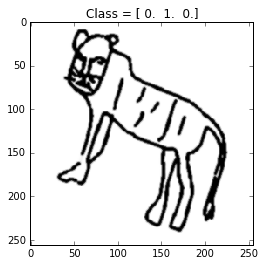

0.0 1.0


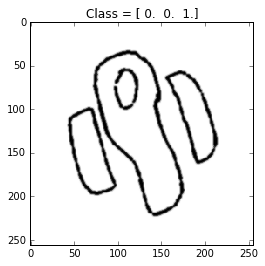

0.0 1.0


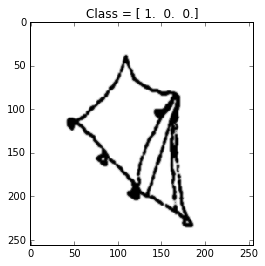

0.0 1.0


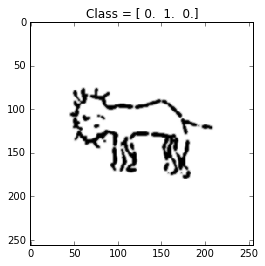

0.0 1.0


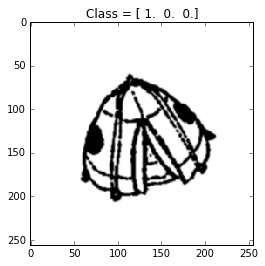

0.0 1.0


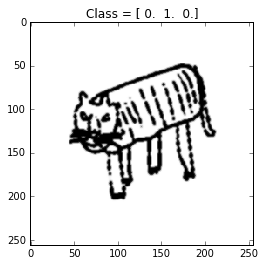

0.0 1.0


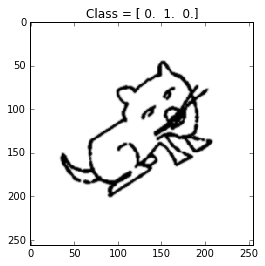

0.0 1.0


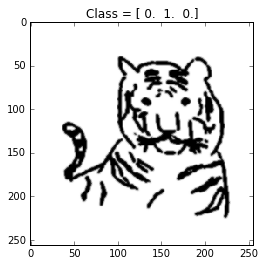

0.0 1.0


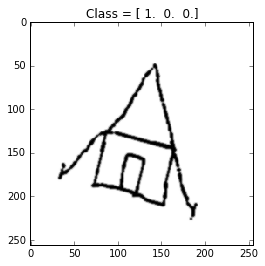

0.0 1.0


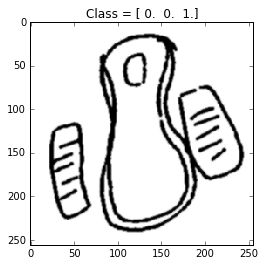

In [50]:
model = keras.models.load_model('../models/sketchnet4_4/latest.h5')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()